# Segmentation Inference Example

This notebooks aims to demo the inference on a custom data sample, instead of using pre-defined tfds dataset. To execute this notebook, please follow the [README](https://github.com/mathpluscode/ImgX-DiffSeg) to install the `imgx` package locally.

In [1]:
from pathlib import Path
import numpy as np
import jax
from flax.training import common_utils
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from imgx.task.segmentation.experiment import SegmentationExperiment
from imgx_datasets.constant import IMAGE, LABEL
from imgx_datasets.save import load_2d_grayscale_image

/Users/yunguanfu/miniforge3/envs/imgx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load a model

The model is a supervisedly trained four-layer U-net with channels [8, 16, 32, 64].

In [2]:
config_path = "config.yaml" # backup config stored
ckpt_dir = "files/ckpt"
step = 1300

In [3]:
config = OmegaConf.load(config_path)
run = SegmentationExperiment(config=config)
train_state, _ = run.train_init(ckpt_dir=ckpt_dir, step=step) # still loads data from tfds

## Evaluate on a custom image

`BB_anon_348_1` is a training data from `muscle_us` data set.

In [4]:
seed = 0
out_dir = Path("outputs")

image = load_2d_grayscale_image("BB_anon_348_1.png", dtype=np.float32)
label = load_2d_grayscale_image("BB_anon_348_1_mask.png")
# image.shape =  (1, 1, 480, 512, 1) label.shape = (1, 1, 480, 512)
# the first axis is shard axis for pmap, the second axis is batch axis
batch = {IMAGE:image[None, None,..., None], LABEL:label[None, None, ...]}
uids = ["BB_anon_348_1"]

In [5]:
device_cpu = jax.devices("cpu")[0]
key = jax.random.PRNGKey(seed)
key = common_utils.shard_prng_key(key)

metrics, label_pred, key = run.eval_batch(
                train_state=train_state,
                key=key,
                batch=batch,
                uids=uids,
                device_cpu=device_cpu,
                out_dir=out_dir,
            )

## Visualize output

In [6]:
# get scalar values
print(jax.tree_map(lambda x: x.item(), metrics))

{'binary_dice_score_class_0': 0.9822485446929932, 'binary_dice_score_class_1': 0.934889554977417, 'centroid_dist_class_0': 1.7067033052444458, 'centroid_dist_class_1': 3.3515679836273193, 'class_0_proportion_label': 0.7809703946113586, 'class_0_proportion_pred': 0.7905650734901428, 'class_1_proportion_label': 0.21902620792388916, 'class_1_proportion_pred': 0.209431454539299, 'hausdorff_dist_class_0': 11.313708498984761, 'hausdorff_dist_class_1': 25.09479504037782, 'iou_class_0': 0.9651163220405579, 'iou_class_1': 0.8777395486831665, 'mean_binary_dice_score': 0.9585690498352051, 'mean_binary_dice_score_without_background': 0.934889554977417, 'mean_centroid_dist': 2.5291357040405273, 'mean_centroid_dist_without_background': 3.3515679836273193, 'mean_hausdorff_dist': 18.204251769681292, 'mean_hausdorff_dist_without_background': 25.09479504037782, 'mean_iou': 0.9214279651641846, 'mean_iou_without_background': 0.8777395486831665, 'mean_mean_surface_dist': 4.810380502239952, 'mean_mean_surfa

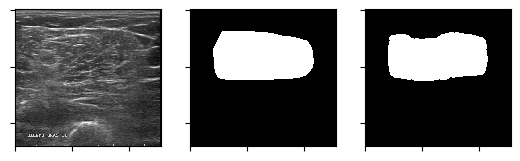

In [7]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image, cmap='gray',  interpolation='nearest')
axs[1].imshow(label, cmap='gray',  interpolation='nearest')
axs[2].imshow(label_pred[0], cmap='gray',  interpolation='nearest')
for i in range(3):
    axs[i].xaxis.set_tick_params(labelbottom=False)
    axs[i].yaxis.set_tick_params(labelleft=False)